In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2

In [5]:
# control points in image coordinates: P1(305, 440), P2(672, 430), P3(480, 704), P4(971,630)
# destination points in 'world coordinates': P1(0, 0), P2(449, 0), P3(0, 465), P4(449, 465)
def calculate_projective_transformation(control_points, destination_points):
    """ calculates the homography for given control and destination points.
    
    - construct a matrix containing both the control and destination points 
    - calculate the svd to find the homography
    
    """
    affine_trans = []
    
    if not len(control_points) == len(destination_points):
        raise Exception('Number of control points must match number of destination points')
    
    for index in range(0, len(control_points)):
        x_control, y_control = control_points[index]
        x_dest, y_dest = destination_points[index]
        
        matrix_entry_1 = [x_control, y_control, 1, 0, 0, 0, -x_dest*x_control, -x_dest*y_control, -x_dest]
        matrix_entry_2 = [0, 0, 0, x_control, y_control, 1, -y_dest*x_control, -y_dest*y_control, -y_dest]
        
        affine_trans.append(matrix_entry_1)
        affine_trans.append(matrix_entry_2)
    
    affine_trans = np.array(affine_trans)    
    
    u, s, v = np.linalg.svd(affine_trans)
    homography = v[-1, :]
    homography = homography.reshape(3, 3)
    homography = homography / homography[2, 2] 
    
    return homography


def apply_projective_transformation(image_path, control_points, destination_points):
    """
    
    """
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    homography = calculate_projective_transformation(control_points, destination_points)
    
    for point in destination_points:
        point_homogenous = np.append(np.array(point), 1)
        point_trans = np.dot(homography, point_homogenous)
        point_trans /= point_trans[2]
        print(point_trans)
        

In [6]:
def projective_transform(image_path, h, output_shape=None, interpolation='nearest'):
    """
    """
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if output_shape is None:
        output_shape = image.shape[:2]

    h_inv = np.linalg.inv(h)
    h_out, w_out = output_shape
    channels = image.shape[2] if image.ndim == 3 else 1

    # Neues leeres Bild
    if channels > 1:
        transformed_image = np.zeros((h_out, w_out, channels), dtype=image.dtype)
    else:
        transformed_image = np.zeros((h_out, w_out), dtype=image.dtype)

    for y in range(h_out):
        for x in range(w_out):
            # Zielpunkt als homogene Koordinate
            dst_point = np.array([x, y, 1])
            src_point = h_inv @ dst_point
            src_point /= src_point[2]

            src_x, src_y = src_point[:2]

            # Interpolation
            if interpolation == 'nearest':
                src_x_ = int(round(src_x))
                src_y_ = int(round(src_y))
                if 0 <= src_x_ < image.shape[1] and 0 <= src_y_ < image.shape[0]:
                    transformed_image[y, x] = image[src_y_, src_x_]

    return transformed_image


def projective_equalization(image_path, destination_points, control_points, output_shape):
    """
    
    """
    homography = calculate_projective_transformation(control_points, destination_points)
    image_new = projective_transform(image_path, homography, output_shape)
    
    plt.title("Entzerrtes Bild")
    plt.imshow(image_new)
    plt.axis("off")
    

[818.42924875 632.98183983   1.        ]
[1.10746447e+03 5.86158819e+02 1.00000000e+00]
[1.28675869e+03 8.13855641e+02 1.00000000e+00]
[1.51025840e+03 6.62560246e+02 1.00000000e+00]


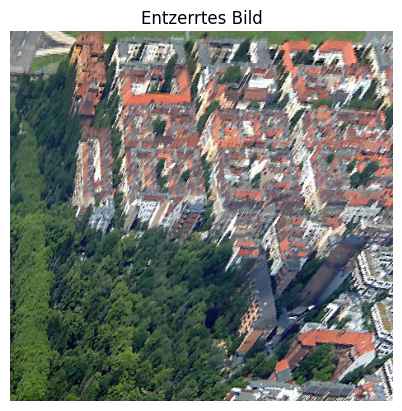

In [7]:
def main():
    control_points = [[305, 440], [672, 430], [480, 704], [971, 630]]
    destination_points = [[0,0], [449, 0], [0, 465], [449, 465]]
    
    apply_projective_transformation('schraegbild_tempelhof.jpg', destination_points, control_points)
    
    projective_equalization('schraegbild_tempelhof.jpg', destination_points, control_points, (449, 465))
    
if __name__ == '__main__':
    main()

[305. 440.   1.]
[672. 430.   1.]
[480. 704.   1.]
[971. 630.   1.]


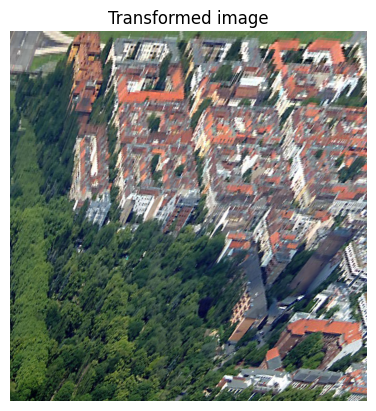